# Before

## Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, accuracy_score)
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D,
    Dropout, Dense, LayerNormalization, Add, MaxPooling2D)

## Optimasi (bonus)

In [ ]:
# 1. Mixed Precision (2x lebih cepat di GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision: ON")

# 2. XLA Compilation (10-20% lebih cepat)
tf.config.optimizer.set_jit(True)
print("✅ XLA Compilation: ON")

# 3. GPU Memory Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU: {gpus[0].name}")
else:
    print("❌ GPU TIDAK DITEMUKAN! Ganti ke GPU runtime!")

✅ Mixed Precision: ON
✅ XLA Compilation: ON
✅ GPU: /physical_device:GPU:0


## Copy data

In [ ]:
!unzip "/content/drive/MyDrive/Data.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data_val/ID_18fe27e2d.png  
  inflating: /content/data_val/ID_190b378c6.png  
  inflating: /content/data_val/ID_190f6e143.png  
  inflating: /content/data_val/ID_1910bc587.png  
  inflating: /content/data_val/ID_1914bb62e.png  
  inflating: /content/data_val/ID_1917cb295.png  
  inflating: /content/data_val/ID_191978e6e.png  
  inflating: /content/data_val/ID_191c119cf.png  
  inflating: /content/data_val/ID_192298944.png  
  inflating: /content/data_val/ID_193205e41.png  
  inflating: /content/data_val/ID_193c72417.png  
  inflating: /content/data_val/ID_19518e3fe.png  
  inflating: /content/data_val/ID_19589334b.png  
  inflating: /content/data_val/ID_19847181a.png  
  inflating: /content/data_val/ID_19943b0f4.png  
  inflating: /content/data_val/ID_199932b81.png  
  inflating: /content/data_val/ID_19a57a946.png  
  inflating: /content/data_val/ID_19ae6df92.png  
  inflating: /content/data_val/ID_19c1681fb.png  

# Pre-train


## Config

In [ ]:
CONFIG = {
    #input
    "INPUT_SHAPE": (256,256, 3),
    "NUM_CLASSES": 6,
    "LEARNING_RATE": 1e-4,
    "MIN_LEARNING_RATE": 1e-5,
    "BATCH_SIZE": 128,
    "EPOCHS": 50,
    "PATIANCE_STOP": 7,
    "PATIANCE_LR": 3,
    "FACTOR":0.5,

    #path
    "TRAIN_DIR": "/content/data_train",
    "VAL_DIR": "/content/data_val",
    "TEST_DIR": "/content/data_test",
    "TRAIN_CSV": "/content/data_train.csv",
    "VAL_CSV": "/content/data_val.csv",
    "TEST_CSV": "/content/data_test.csv",
    "MODEL_SAVE_PATH": "/content/drive/MyDrive/hasil/conx.keras"}

label_cols = ["any","intraparenchymal","intraventricular","subarachnoid","subdural","epidural"]

## Data

In [ ]:
train_df = pd.read_csv(CONFIG["TRAIN_CSV"])
val_df   = pd.read_csv(CONFIG["VAL_CSV"])
test_df  = pd.read_csv(CONFIG["TEST_CSV"])

for df in [train_df, val_df, test_df]:
    df["ImageID"] = df["ImageID"].apply(lambda x: x if x.endswith(".png") else x + ".png")


In [ ]:
# Hitung jumlah positif dan negatif di tiap label
for col in label_cols:
    counts = train_df[col].value_counts()
    total = counts.sum()
    positive = counts.get(1, 0)
    negative = counts.get(0, 0)
    balance_ratio = positive / total * 100
    print(f"{col:17} | Positif: {positive:5d} | Negatif: {negative:5d} | Rasio positif: {balance_ratio:6.2f}%")


any               | Positif: 41737 | Negatif:  8000 | Rasio positif:  83.92%
intraparenchymal  | Positif: 15130 | Negatif: 34607 | Rasio positif:  30.42%
intraventricular  | Positif: 12010 | Negatif: 37727 | Rasio positif:  24.15%
subarachnoid      | Positif: 14569 | Negatif: 35168 | Rasio positif:  29.29%
subdural          | Positif: 15576 | Negatif: 34161 | Rasio positif:  31.32%
epidural          | Positif:  8000 | Negatif: 41737 | Rasio positif:  16.08%


In [ ]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=5,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],
    fill_mode="nearest"
)
datagen_plain = ImageDataGenerator()

train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=CONFIG["TRAIN_DIR"],
    x_col="ImageID",
    y_col=label_cols,
    target_size=CONFIG["INPUT_SHAPE"][:2],
    batch_size=CONFIG["BATCH_SIZE"],
    class_mode="raw",
    shuffle=True
)

val_gen = datagen_plain.flow_from_dataframe(
    dataframe=val_df,
    directory=CONFIG["VAL_DIR"],
    x_col="ImageID",
    y_col=label_cols,
    target_size=CONFIG["INPUT_SHAPE"][:2],
    batch_size=CONFIG["BATCH_SIZE"],
    class_mode="raw",
    shuffle=False
)

test_gen = datagen_plain.flow_from_dataframe(
    dataframe=test_df,
    directory=CONFIG["TEST_DIR"],
    x_col="ImageID",
    y_col=label_cols,
    target_size=CONFIG["INPUT_SHAPE"][:2],
    batch_size=CONFIG["BATCH_SIZE"],
    class_mode="raw",
    shuffle=False
)

Found 49737 validated image filenames.
Found 5530 validated image filenames.
Found 5530 validated image filenames.


## Model

In [ ]:
model_base = ConvNeXtBase(
    include_top=False,
    # include_preprocessing=True,
    weights="imagenet",
    input_shape=CONFIG["INPUT_SHAPE"]
)
model_base.trainable = False

In [ ]:
for layer in model_base.layers[-50:]:
    layer.trainable = True

In [ ]:
input_layer = model_base.input
x = model_base.output

# Head
x = GlobalAveragePooling2D()(x)
x = LayerNormalization(name="classifier_norm")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(CONFIG["NUM_CLASSES"], activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

In [ ]:
# Cek arsitektur
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 256, 256,  │          0 │ input_layer_5[0]… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 64, 64,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 64, 64,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │      6,400 │ add_36[0][0]      │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 64, 64,    │        128 │ convnext_base_st

 Total params: 88,159,750 (336.30 MB)

 Trainable params: 36,520,326 (139.31 MB)

 Non-trainable params: 51,639,424 (196.99 MB)

## Callback & loss

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=CONFIG["PATIANCE_STOP"],
    restore_best_weights=True
    )

checkpoint = ModelCheckpoint(
    filepath=CONFIG["MODEL_SAVE_PATH"],
    monitor='val_loss',
    save_best_only=True
    )

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=CONFIG["FACTOR"],
    patience=CONFIG["PATIANCE_LR"],
    min_lr=CONFIG["MIN_LEARNING_RATE"],
    )

In [ ]:
@tf.function
def weighted_bce(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # BCE manual
    loss_pos = -y_true * tf.math.log(y_pred + 1e-7) * pos_weights
    loss_neg = -(1 - y_true) * tf.math.log(1 - y_pred + 1e-7)

    loss = loss_pos + loss_neg
    return tf.reduce_mean(loss)

## Eval


In [ ]:
def evaluate_model_comprehensive(model, history, test_gen, label_cols, threshold=0.5):
    """
    Evaluasi menyeluruh: Loss Curve, Metrics Report, ROC-AUC, dan Confusion Matrix.
    Pastikan test_gen memiliki shuffle=False.
    """

    # 1. Visualisasi Loss & Accuracy Curve
    print("--- 1. Visualisasi Training History ---")
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 2. Prediksi
    print("\n--- 2. Melakukan Prediksi ---")
    test_gen.reset() # Reset generator agar urutan data sesuai
    y_true = test_gen.labels
    y_pred = model.predict(test_gen, verbose=1)
    y_pred_binary = (y_pred > threshold).astype(int)

    # 3. Metrik Klasifikasi (Akurasi, Presisi, Recall, F1-Score)
    print("\n--- 3. Classification Report (Precision, Recall, F1-Score) ---")
    # Menghitung akurasi global (exact match ratio)
    acc_global = accuracy_score(y_true, y_pred_binary)
    eval_results = model.evaluate(test_gen, verbose=0)
    global_loss = eval_results[0]  # Indeks 0 biasanya adalah Loss

    print(f"Global Exact Match Accuracy: {acc_global:.4f}\n")
    print(f"Global Loss     : {global_loss:.4f}\n")

    # Laporan lengkap per kelas
    print(classification_report(y_true, y_pred_binary, target_names=label_cols, zero_division=0))

    # 4. ROC-AUC Score & Curve
    print("\n--- 4. ROC-AUC Score & Visualization ---")
    roc_scores = {}
    plt.figure(figsize=(10, 7))

    for i, label in enumerate(label_cols):
        try:
            # Hitung skor AUC
            score = roc_auc_score(y_true[:, i], y_pred[:, i])
            roc_scores[label] = score

            # Hitung kurva ROC
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
            plt.plot(fpr, tpr, label=f"{label} (AUC = {score:.3f})")
        except ValueError:
            print(f"Warning: Label '{label}' hanya memiliki satu kelas di data test.")

    # Plotting ROC Global
    plt.plot([0, 1], [0, 1], 'k--', lw=1) # Garis diagonal random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve per Label", fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Cetak Rata-rata AUC
    mean_roc = np.nanmean(list(roc_scores.values()))
    print(f"Macro Average ROC-AUC: {mean_roc:.4f}")

    # 5. Confusion Matrix per Label
    print("\n--- 5. Confusion Matrix per Label ---")
    # Mengatur grid plot otomatis berdasarkan jumlah label
    n_labels = len(label_cols)
    cols = 3
    rows = (n_labels + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))

    for i, label in enumerate(label_cols):
        cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])

        ax = plt.subplot(rows, cols, i + 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
        disp.plot(cmap='Blues', ax=ax, colorbar=False)
        ax.set_title(f'CM - {label}', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Train

In [ ]:
pos_weights = tf.constant([0.19, 2.29, 3.14, 2.41, 2.19, 5.22], dtype=tf.float32)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=CONFIG["LEARNING_RATE"]),
    loss=weighted_bce,
    metrics=["accuracy", Precision(name="Precision"), Recall(name="Recall")]
)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    epochs=CONFIG["EPOCHS"]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.4462 - Recall: 0.5959 - accuracy: 0.1804 - loss: 0.8912

389/389 ━━━━━━━━━━━━━━━━━━━━ 1256s 3s/step - Precision: 0.4463 - Recall: 0.5960 - accuracy: 0.1805 - loss: 0.8910 - val_Precision: 0.6084 - val_Recall: 0.7783 - val_accuracy: 0.4467 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 2/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.5912 - Recall: 0.7415 - accuracy: 0.2922 - loss: 0.6759

389/389 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - Precision: 0.5912 - Recall: 0.7415 - accuracy: 0.2922 - loss: 0.6759 - val_Precision: 0.6289 - val_Recall: 0.7348 - val_accuracy: 0.3195 - val_loss: 0.6160 - learning_rate: 1.0000e-04
Epoch 3/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.6365 - Recall: 0.7844 - accuracy: 0.3336 - loss: 0.6038

389/389 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - Precision: 0.6365 - Recall: 0.7844 - accuracy: 0.3336 - loss: 0.6038 - val_Precision: 0.6586 - val_Recall: 0.7218 - val_accuracy: 0.1888 - val_loss: 0.5893 - learning_rate: 1.0000e-04
Epoch 4/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.6799 - Recall: 0.8026 - accuracy: 0.3193 - loss: 0.5399

389/389 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - Precision: 0.6799 - Recall: 0.8026 - accuracy: 0.3194 - loss: 0.5399 - val_Precision: 0.7002 - val_Recall: 0.7446 - val_accuracy: 0.2732 - val_loss: 0.5423 - learning_rate: 1.0000e-04
Epoch 5/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.7113 - Recall: 0.8249 - accuracy: 0.3383 - loss: 0.4909

389/389 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - Precision: 0.7113 - Recall: 0.8249 - accuracy: 0.3383 - loss: 0.4909 - val_Precision: 0.7226 - val_Recall: 0.7157 - val_accuracy: 0.1723 - val_loss: 0.5409 - learning_rate: 1.0000e-04
Epoch 6/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - Precision: 0.7328 - Recall: 0.8370 - accuracy: 0.3360 - loss: 0.4538 - val_Precision: 0.7367 - val_Recall: 0.7353 - val_accuracy: 0.2304 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 7/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.7532 - Recall: 0.8484 - accuracy: 0.3561 - loss: 0.4219

389/389 ━━━━━━━━━━━━━━━━━━━━ 825s 2s/step - Precision: 0.7532 - Recall: 0.8484 - accuracy: 0.3560 - loss: 0.4218 - val_Precision: 0.7276 - val_Recall: 0.7952 - val_accuracy: 0.3092 - val_loss: 0.5130 - learning_rate: 1.0000e-04
Epoch 8/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.7754 - Recall: 0.8679 - accuracy: 0.3871 - loss: 0.3850

389/389 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - Precision: 0.7754 - Recall: 0.8679 - accuracy: 0.3870 - loss: 0.3851 - val_Precision: 0.7408 - val_Recall: 0.8181 - val_accuracy: 0.2877 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 9/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - Precision: 0.7915 - Recall: 0.8726 - accuracy: 0.3867 - loss: 0.3621 - val_Precision: 0.7533 - val_Recall: 0.7958 - val_accuracy: 0.2902 - val_loss: 0.4944 - learning_rate: 1.0000e-04
Epoch 10/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - Precision: 0.8081 - Recall: 0.8861 - accuracy: 0.4179 - loss: 0.3313 - val_Precision: 0.7598 - val_Recall: 0.7974 - val_accuracy: 0.2523 - val_loss: 0.4915 - learning_rate: 1.0000e-04
Epoch 11/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - Precision: 0.8237 - Recall: 0.8925 - accuracy: 0.4164 - loss: 0.3074 - val_Precision: 0.7803 - val_Recall: 0.7822 - val_accuracy: 0.2438 - val_loss: 0.5215 - learning_rate: 1.0000e-04
Epoch 12/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step

--- 1. Visualisasi Training History ---


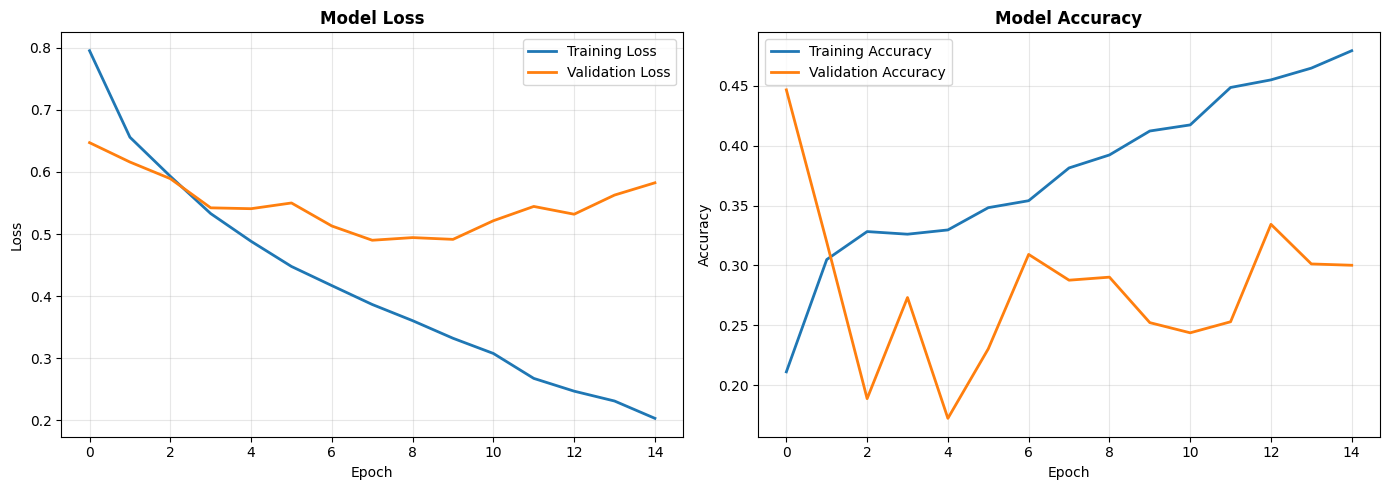


--- 2. Melakukan Prediksi ---
44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step

--- 3. Classification Report (Precision, Recall, F1-Score) ---
Global Exact Match Accuracy: 0.4031

Global Loss     : 0.4771

                  precision    recall  f1-score   support

             any       0.96      0.86      0.91      4530
intraparenchymal       0.76      0.76      0.76      1733
intraventricular       0.67      0.90      0.77      1437
    subarachnoid       0.50      0.81      0.61      1695
        subdural       0.67      0.77      0.72      1773
        epidural       0.80      0.57      0.67       310

       micro avg       0.74      0.82      0.78     11478
       macro avg       0.73      0.78      0.74     11478
    weighted avg       0.78      0.82      0.79     11478
     samples avg       0.62      0.67      0.63     11478


--- 4. ROC-AUC Score & Visualization ---


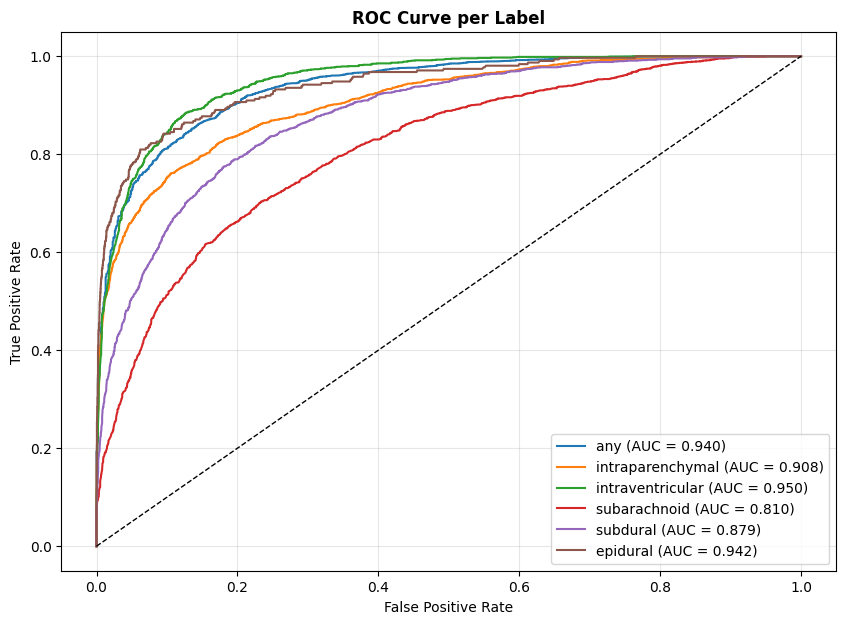

Macro Average ROC-AUC: 0.9049

--- 5. Confusion Matrix per Label ---


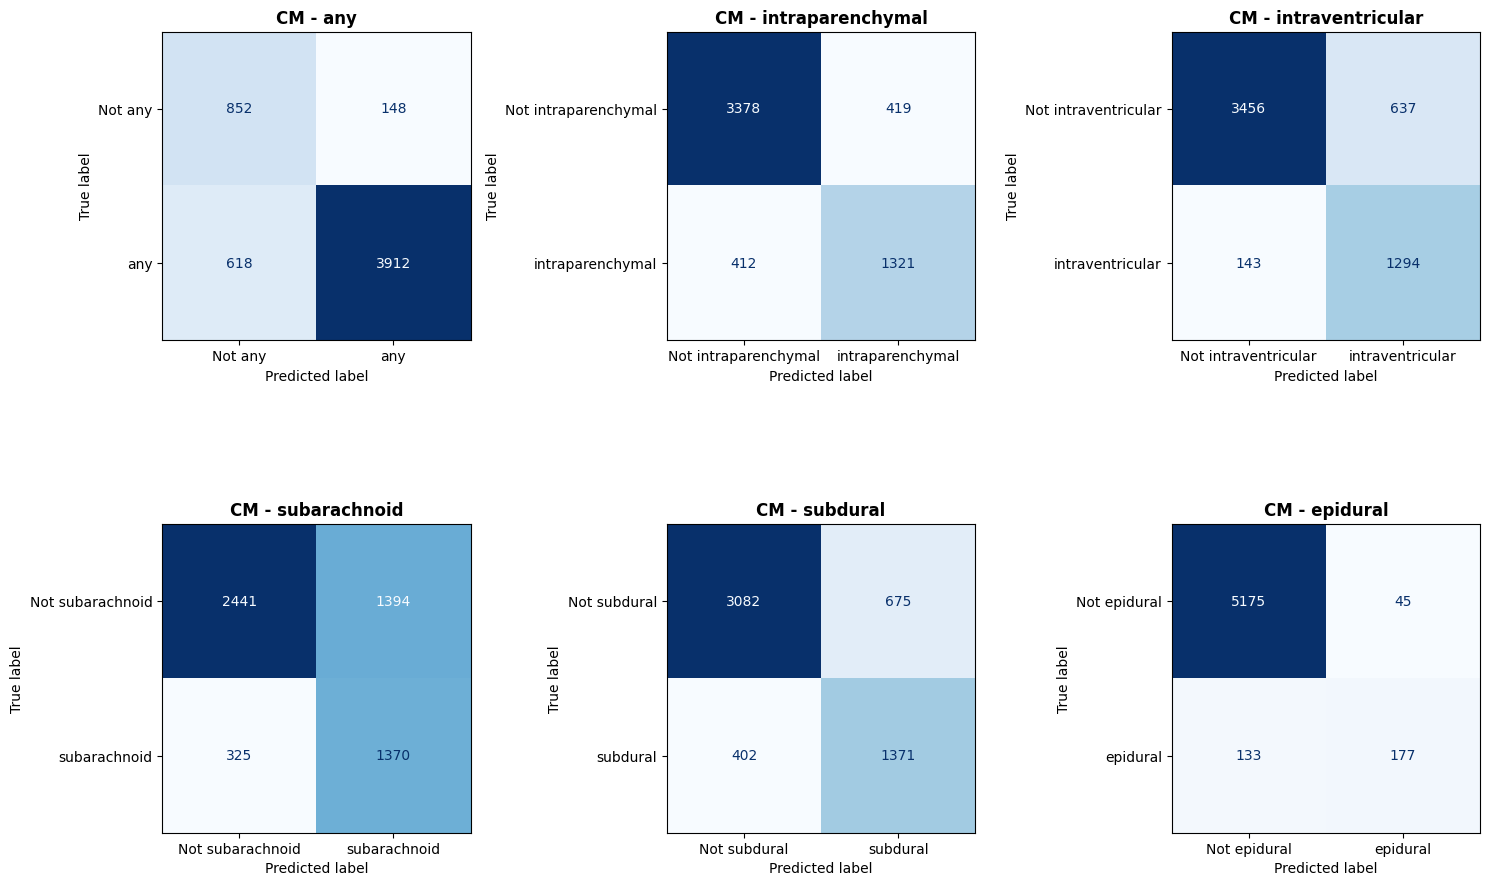

In [ ]:
evaluate_model_comprehensive(model, history, test_gen, label_cols)

In [ ]:
model.save("/content/drive/MyDrive/hasil/conx.keras")